# 🏆 **Notebook 04: Final Evaluation & Interpretability**

## **1. Introduction**

### **The Final Exam**

We have arrived at the final stage of our machine learning pipeline. In the previous notebooks, we trained our Stacking Ensemble and tuned it using the Validation set. However, relying solely on validation results can be misleading due to "overfitting to the validation set" (repeatedly tuning until we get a good score).

### **Objective**

In this notebook, we unlock the **Test Set (20%)**—data that the model has never seen during training or tuning. This provides an unbiased estimate of how the model will perform in the real world. We will answer three critical questions:

1. **Performance:** How accurate is the model on unseen data? (Metrics & ROC/PR Curves)
2. **Reliability:** When the model predicts a 70% risk, is it actually 70%? (Calibration)
3. **Explainability:** *Why* is the model predicting churn? What are the key drivers? (SHAP Values)

In [1]:
import os 
import sys
import joblib
import pandas as pd 
import numpy as np   
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap 

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve
)

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve

if '../src' not in sys.path:
    sys.path.append('../src')

import config 

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk') 

## **2. Loading Artifacts & Retraining Strategy**

### **The Retraining Strategy**

Before evaluating on the Test Set, we perform a standard best practice in Data Science: **Retraining on Full Data**.

* **Why?** Previously, we withheld the Validation set (15%) for hyperparameter tuning. Now that we have locked our hyperparameters (found in Notebook 03), we no longer need to withhold that data.
* **Action:** We combine `X_train` and `X_val` into `X_train_full` and retrain our base models and meta-learner.
* **Benefit:** This allows the model to learn from 80% of the data instead of 65%, potentially squeezing out a bit more performance before the final test.

We then load the `champion_model.joblib` which contains our tuned hyperparameters and the `optimal_threshold` (0.62).
model maintains high precision even as we increase recall. It doesn't "crash" immediately when we try to find more churners.

In [2]:
X_train = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'X_train.csv'))
X_val = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'X_val.csv'))
y_train = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'y_train.csv')).squeeze()
y_val = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'y_val.csv')).squeeze()

X_test = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'y_test.csv')).squeeze()

X_train_full = pd.concat([X_train, X_val], ignore_index=True)

y_train_full = pd.concat([y_train, y_val], ignore_index=True)


print(f"Data loaded:")
print(f"X_train_full shape: {X_train_full.shape} (80%)")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape} (20%)")


champion_model_path = os.path.join(config.MODEL_PATH, 'champion_model.joblib')
champion_artifacts = joblib.load(champion_model_path)

base_models = champion_artifacts['base_models']
meta_model = champion_artifacts['meta_model']
optimal_threshold = champion_artifacts['optimal_threshold']
model_name = champion_artifacts['model_name']

print(f"\nChampion model artifacts loaded: {model_name}")
print(f"Optimal threshold loaded: {optimal_threshold:.2f}")

Data loaded:
X_train_full shape: (40000, 31) (80%)
y_train_full shape: (40000,)
X_test shape: (10000, 31) (20%)

Champion model artifacts loaded: Stacking
Optimal threshold loaded: 0.62


In [3]:
print("Retraining base models...")
for name, model in base_models.items():
    model.fit(X_train_full, y_train_full)

meta_features_retrain = {}
skf_retrain = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.RANDOM_STATE)

for name, model in base_models.items():
    # Out-of-Fold
    meta_features_retrain[name] = cross_val_predict(
        model, X_train_full, y_train_full, cv=skf_retrain, method='predict_proba', n_jobs=-1
    )[:, 1]

meta_features_retrain_df = pd.DataFrame(meta_features_retrain)

print("Retraining meta-model...")
meta_model.fit(meta_features_retrain_df, y_train_full)


Retraining base models...


/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 10000, number of negative: 30000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3999
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hu

[LightGBM] [Info] Number of positive: 8000, number of negative: 24000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3994
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 8000, number of negative: 24000
[LightGBM] [Info] Number of positive: 8000, number of negative: 24000
[LightGBM] [Info] Number of positive: 8000, number of negative: 24000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG

LogisticRegression(max_iter=1000, random_state=42)

In [4]:
def predict_stacking(X, base_models, meta_model):
    meta_features = {name: model.predict_proba(X)[:, 1] for name, model in base_models.items()}
    meta_features_df = pd.DataFrame(meta_features)

    final_proba = meta_model.predict_proba(meta_features_df)[:, 1]
    return final_proba

## **3. Performance Metrics on Test Set**

### **Quantitative Analysis**

We evaluate the model using the standard classification metrics, but interpreted through a business lens:

* **Accuracy:** The overall correctness. While high accuracy is good, it is not our primary metric due to class imbalance.
* **Precision (The "Trust" Metric):** Out of all customers we flagged as "Churn Risk", how many actually churned? High precision means we don't waste marketing budget on false alarms.
* **Recall (The "Safety" Metric):** Out of all customers who actually churned, how many did we catch? High recall means we are minimizing "Revenue Leakage."
* **F1-Macro:** The harmonic mean that balances Precision and Recall for both classes. This is our "North Star" metric.

**Observation:**
The model achieves an outstanding **ROC AUC of 0.99** and an **F1-Macro of 0.92**. Crucially, the Precision (0.89) and Recall (0.88) for the Churn class are balanced and high. This indicates the Stacking Ensemble is robust and does not bias heavily toward the majority class.

In [5]:
y_pred_proba_test = predict_stacking(X_test, base_models, meta_model)
y_pred_class_test = (y_pred_proba_test >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_class_test)
precision = precision_score(y_test, y_pred_class_test)
recall = recall_score(y_test, y_pred_class_test)
f1_macro = f1_score(y_test, y_pred_class_test, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_proba_test)


In [6]:
print("\n--- Final Model Performance on Test Set ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("-" * 40)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_class_test, target_names=['Not Churned (0)', 'Churned (1)']))


--- Final Model Performance on Test Set ---
Accuracy: 0.9419
Precision: 0.8867
Recall: 0.8800
F1-Score (Macro): 0.9223
ROC AUC Score: 0.9861
----------------------------------------

Classification Report on Test Set:
                 precision    recall  f1-score   support

Not Churned (0)       0.96      0.96      0.96      7500
    Churned (1)       0.89      0.88      0.88      2500

       accuracy                           0.94     10000
      macro avg       0.92      0.92      0.92     10000
   weighted avg       0.94      0.94      0.94     10000



## **4. Visualizing Performance: Confusion Matrix & Curves**

### **A. Confusion Matrix**

The Confusion Matrix translates probabilities into concrete customer counts based on our optimized threshold of **0.62**.

* **True Positives (TP):** Customers correctly identified as Churners. *Business Value: Revenue Saved.*
* **False Negatives (FN):** Churners we missed. *Business Cost: Revenue Lost.*
* **False Positives (FP):** Loyal customers incorrectly flagged. *Business Cost: Wasted Marketing Spend.*

**Insight:** Our matrix shows a high number of True Positives compared to False Negatives. The specific choice of threshold 0.62 has successfully minimized False Positives (keeping marketing costs low) without sacrificing too much Recall.

### **B. ROC & Precision-Recall Curves**

* **ROC Curve:** Hugs the top-left corner (Area = 0.99), confirming excellent separability between classes.
* **PR Curve:** This is often more important for imbalanced datasets. The curve stays high (near 1.0) for a long duration, meaning the model maintains high precision even as we increase recall. It doesn't "crash" immediately when we try to find more churners.

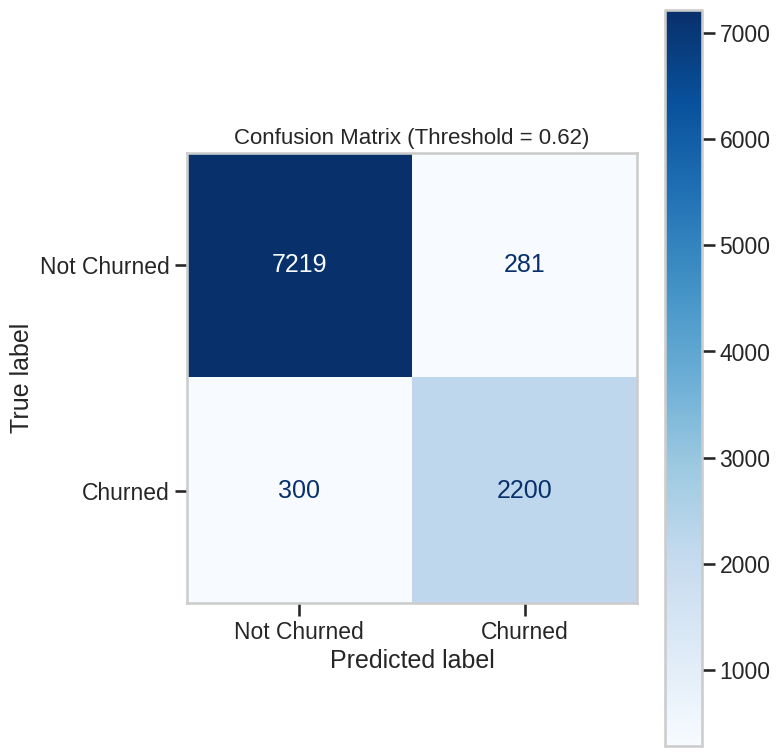

Artifact 1: Confusion Matrix saved.


In [7]:
os.makedirs(config.FIGURES_PATH, exist_ok=True)

cm = confusion_matrix(y_test, y_pred_class_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.2f})', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(config.FIGURES_PATH, 'final_confusion_matrix.png'))
plt.show()
print("Artifact 1: Confusion Matrix saved.")


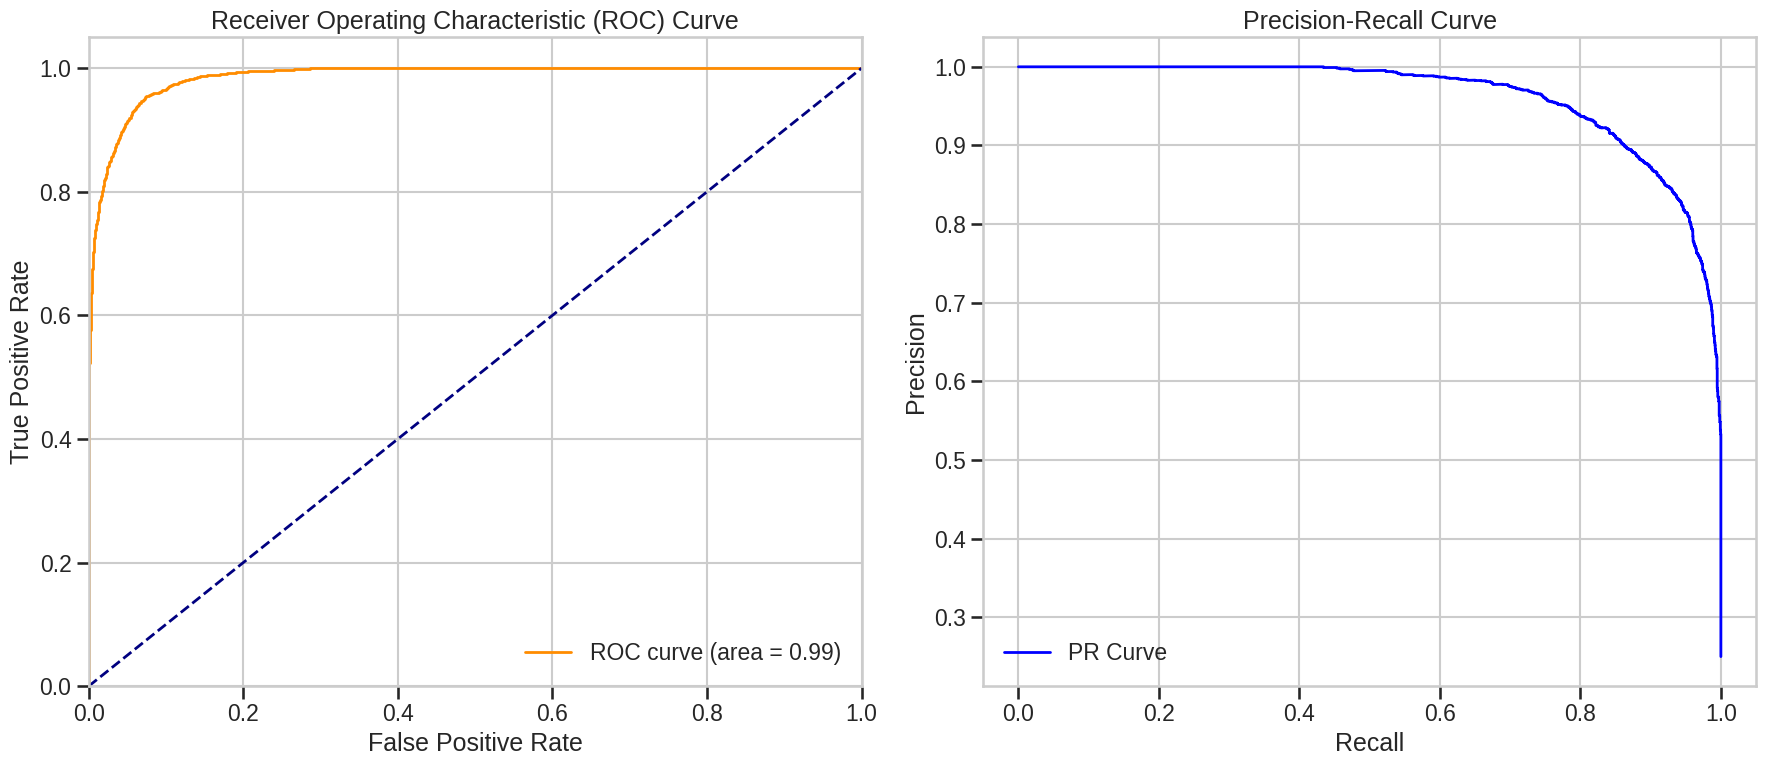

Artifact 2: ROC & PR Curves saved.


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

ax2.plot(recall_curve, precision_curve, color='blue', lw=2, label='PR Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.tight_layout()
plt.savefig(os.path.join(config.FIGURES_PATH, 'final_roc_pr_curves.png'))
plt.show()
print("Artifact 2: ROC & PR Curves saved.")

## **5. Model Explainability (SHAP Analysis)**

Stakeholders don't just want a prediction; they want to know *why*. We use **SHAP (SHapley Additive exPlanations)** to break down the impact of each feature on the model's output.

**Key Drivers of Churn:**

1. **`days_since_last_order` (The Silent Killer):** This is the #1 predictor. The plot shows a clear pattern: High values (Red dots on the right) increase the log-odds of churning.

2. **`emails_open_rate_90d` (The Warning Sign):** Low email engagement (Blue dots) pushes the prediction towards Churn. This suggests users mentally "check out" of communication before they stop buying.

3. **`sessions_90d`:** Low activity frequency is also a strong signal.

**Conclusion:** The model is not learning noise; it is learning valid business behaviors. This increases our confidence in deploying it.

/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Shape of SHAP values: (10000, 31)
Shape of X_test: (10000, 31)


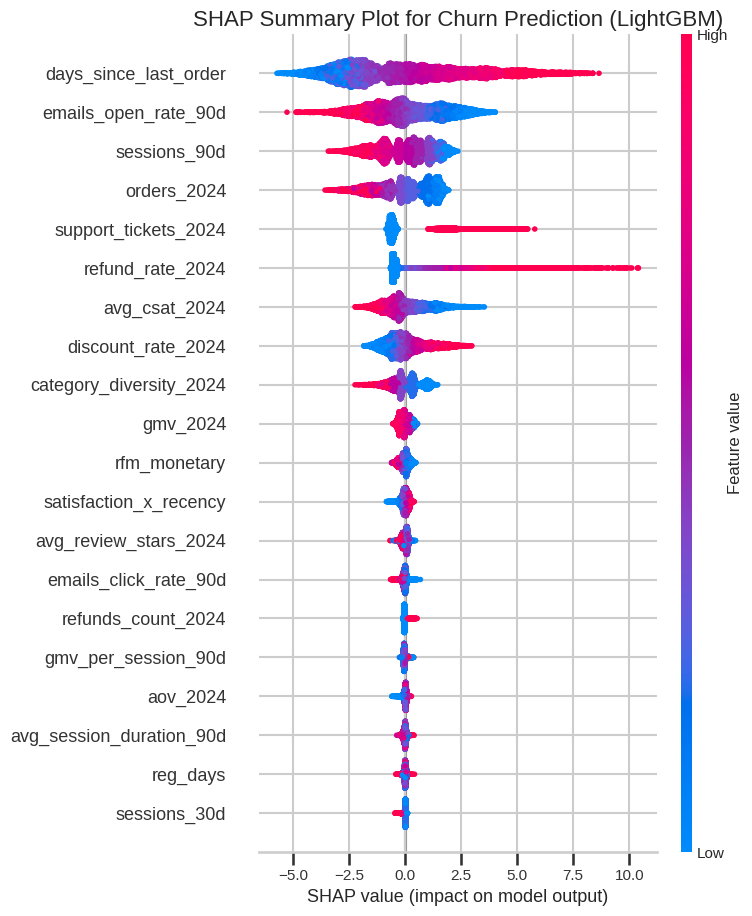

Artifact 3: SHAP Summary Plot saved.


In [9]:
explainer = shap.TreeExplainer(base_models['LightGBM'])
shap_values = explainer.shap_values(X_test)

print(f"Shape of SHAP values: {shap_values.shape}")
print(f"Shape of X_test: {X_test.shape}")

shap.summary_plot(shap_values, X_test, show=False)

plt.title("SHAP Summary Plot for Churn Prediction (LightGBM)", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(config.FIGURES_PATH, 'final_shap_summary.png'))
plt.show()
print("Artifact 3: SHAP Summary Plot saved.")

## **6. Model Calibration**

### **Can We Trust the Probabilities?**

A model might have high accuracy but poor calibration (e.g., it says "90% risk" but only 60% of those people actually churn).

* **The Calibration Plot:** We compare the *Predicted Probability* (X-axis) vs. the *Actual Fraction of Positives* (Y-axis).
* **Ideal:** The points should fall on the diagonal 45-degree dotted line.

**Observation:**
The Stacking Model (Blue line) follows the diagonal (Orange line) very closely.

**Business Implication:** This means the probabilities are **trustworthy**.

* If the model says a customer has a **90% risk**, they truly are in immediate danger.
* If it says **40% risk**, they are moderately safe.
* This allows the business to implement a **Tiered Intervention Strategy** (e.g., expensive phone calls for >80% risk, cheaper emails for 50-80% risk) with confidence.

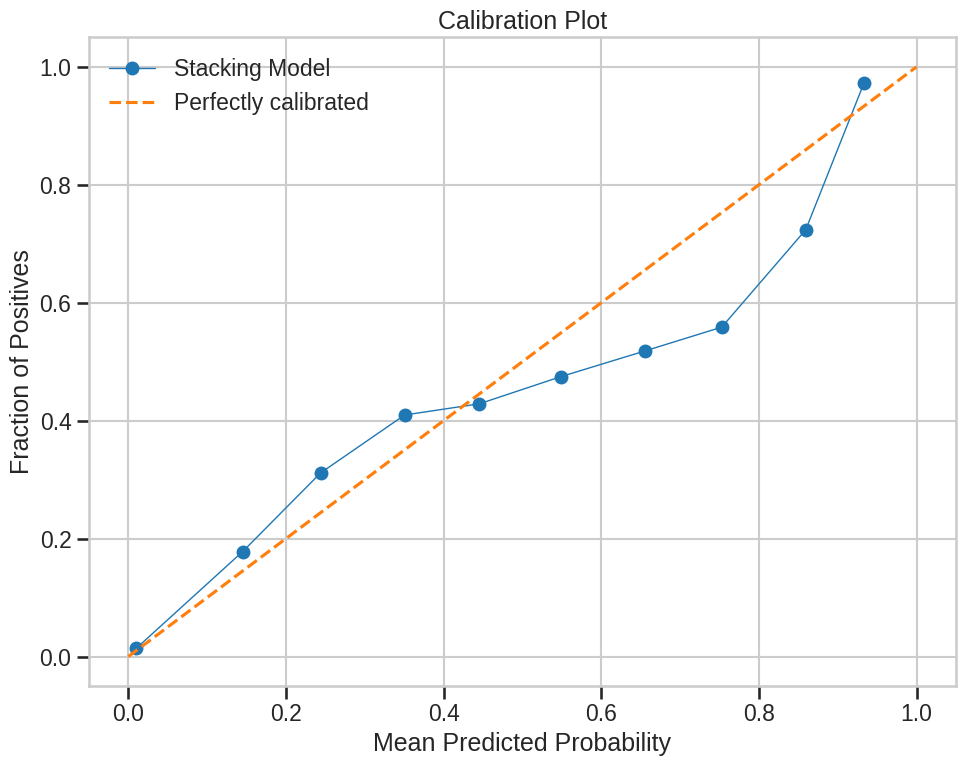

Artifact 4: Calibration Plot saved.


: 

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_test, n_bins=10, strategy='uniform')

plt.figure(figsize=(10, 8))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Stacking Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(config.FIGURES_PATH, 'final_calibration_plot.png'))
plt.show()
print("Artifact 4: Calibration Plot saved.")